![title](logo.png)

# Biometrics System Concepts

# Assignment 1: Fingerprint Recognition

Implement and test a key-point based fingerprint recognition/verification system.

A high-level description is provided with links to or hints of code snippets and libraries that you can reuse/adapt at your will (with proper referencing!).

The following steps need to be implemented:
1. Importing the required packages
2. Reading image data, conversion to gray-scale
3. Preprocessing: Enhancement using orientation/frequency filtering and Segmentation of foreground 
4. "Minutiae" detection using keypoint detectors and descriptors from OpenCV
5. Matching using keypoint matching
6. **Validation using a verification and identification scenario** (cf. previous assignment)

For steps 1-5, code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). 

In [ ]:
import requests
import zipfile

###Note: This notebook is self containe and can be executed directly in colab without uploading the data. To do that one needs to set DOWNLOAD_IMAGE = True.

In [ ]:
DOWNLOAD_IMAGE = False

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
if DOWNLOAD_IMAGE:
   share_able_link = "15h_JVpxHVQHg9e4mJQy9iXHOBd-e2Spz"
   destination  = "data.zip"
   download_file_from_google_drive(share_able_link, destination)
   !unzip "data.zip"

Archive:  data.zip
   creating: fprdata/.ipynb_checkpoints/
  inflating: fprdata/DB1_enhanced.p  
   creating: fprdata/FVC2002/
   creating: fprdata/FVC2002/DB1_B/
  inflating: fprdata/FVC2002/DB1_B/101_1.tif  
  inflating: fprdata/FVC2002/DB1_B/101_2.tif  
  inflating: fprdata/FVC2002/DB1_B/101_3.tif  
  inflating: fprdata/FVC2002/DB1_B/101_4.tif  
  inflating: fprdata/FVC2002/DB1_B/101_5.tif  
  inflating: fprdata/FVC2002/DB1_B/101_6.tif  
  inflating: fprdata/FVC2002/DB1_B/101_7.tif  
  inflating: fprdata/FVC2002/DB1_B/101_8.tif  
  inflating: fprdata/FVC2002/DB1_B/102_1.tif  
  inflating: fprdata/FVC2002/DB1_B/102_2.tif  
  inflating: fprdata/FVC2002/DB1_B/102_3.tif  
  inflating: fprdata/FVC2002/DB1_B/102_4.tif  
  inflating: fprdata/FVC2002/DB1_B/102_5.tif  
  inflating: fprdata/FVC2002/DB1_B/102_6.tif  
  inflating: fprdata/FVC2002/DB1_B/102_7.tif  
  inflating: fprdata/FVC2002/DB1_B/102_8.tif  
  inflating: fprdata/FVC2002/DB1_B/103_1.tif  
  inflating: fprdata/FVC2002/DB1_B/10

## CODE EXAMPLE

### 1. Importing packages


In [ ]:
!pip install pyeer

     |████████████████████████████████| 614kB 7.8MB/s 
  Created wheel for pyeer: filename=pyeer-0.5.4-cp36-none-any.whl size=603835 sha256=732cff9eff03eacd22cac2f46d576720d51e54ad996ebf8cc5129f0dfb58e693
  Stored in directory: /root/.cache/pip/wheels/8c/26/2e/39ca25f59deb5f470fbb378f70b79033719582d9c894e9803f
Successfully built pyeer


In [ ]:
# OpenCV package
import cv2
import matplotlib
# standard array processing package
import numpy as np
# Plotting library
from matplotlib import pyplot as plt
#to plot the figures inside the notebook:
%matplotlib inline
# file path processing package
from pathlib import Path
# local modules for fingerprint enhancement
import fprmodules.enhancement as fe
# package for some simple biometric metrics. 
# Of course you can use the code you have developed in the previous assignment
import pyeer
from sklearn.metrics import roc_curve
# Pickle allows to save and read intermediate results (similar to save and load in Matlab)
import pickle
# a visual progress bar library
from tqdm.notebook import tqdm as tqdm_notebook

### 2. Reading image data and conversion to gray scale

We will make use of the Fingerprint Verification Competition'2002 Database ([FVC'2002](http://bias.csr.unibo.it/fvc2002/default.asp)) images. This was the second in a series of benchmark tests that were made publically available. While we do not have access to the full (880 images) database, you can test your algorithm on a subset of 80 images (10 individuals/fingers, 8 fingerprints per finger). Eventually, you can compare your results to the results that other competitors have uploaded. 

In [ ]:
# read a whole database, stored in a single folder with filenames as XXY.tig with XX the individual number and Y the fingerprint number for this individual
# returns a list of images and a list of associated identity labels

def read_DB(path):
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.tif"))
#     for imagePath in imagePaths:
    for imagePath in tqdm_notebook(imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        label = imagePath.stem[1:3]
        labels.append(label)
    return (images, labels)

# select a Database
images_db1, labels_db1 = read_DB('./fprdata/FVC2002/DB1_B/')
images_db2, labels_db2 = read_DB('./fprdata/FVC2002/DB2_B/')
images_db3, labels_db3 = read_DB('./fprdata/FVC2002/DB3_B/')
images_db4, labels_db4 = read_DB('./fprdata/FVC2002/DB4_B/')

(374, 388)


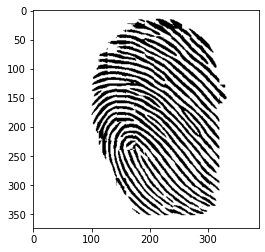

In [ ]:
# # Verify by showing some images
print(images_db1[0].shape)
plt.imshow(images_db1[0],cmap='gray')
plt.show()

### 3. Preprocessing: enhancement using ridge orientation/frequency estimation and segmentation of foreground

We will re-use code developed by [Utkarsh Deshmukh](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python), which is a Python-recode of Matlab-code developed by [Peter Kovesi](https://www.peterkovesi.com/matlabfns/index.html#fingerprints). I have slightly adapted this code to make it more compliant with OpenCV. 

It uses gradient-based orientation and local frequency estimation as input to an orientation and frequency selective filtering using a Gabor filterbank. 

At the same time a foreground region segmentation (mask) is determined by calculating the standard deviation in local windows and thresholding above a certain level. 

In [ ]:
# Calcuate the enhanced images and the associated segmentation masks

def enhance_images(images):

    images_e_u = []
    masks = []
    for i, image in enumerate(tqdm_notebook(images)):
        try:
            # Gabor filtering
            img_e, mask, orientim, freqim = fe.image_enhance(image)
            # Normalize in the [0,255] range
            img_e_u = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
            images_e_u.append(img_e_u)
        except:
            print('error for: ', i)
            images_e_u.append(image)
        masks.append(mask)
    return images_e_u, masks

In [ ]:
# images_enhanced_db1, masks_db1 = enhance_images(images_db1)
# # images_db2 = enhance_images(images_db2)
# # images_db3 = enhance_images(images_db3)
# # images_db4 = enhance_images(images_db4)

In [ ]:
# # intermediate (computation heavy) results can be saved on file using the pickle package
# p_file = open( "./fprdata/DB1_enhanced.p", "wb" )
# pickle.dump([images_enhanced_db1, labels_db1, masks_db1], p_file)


In [ ]:
# and read back for further processing
p_file = open( "./fprdata/DB1_enhanced.p", "rb" )
[images_enhanced_db1, labels_db1, masks_db1] = pickle.load(p_file)

<Figure size 432x288 with 0 Axes>

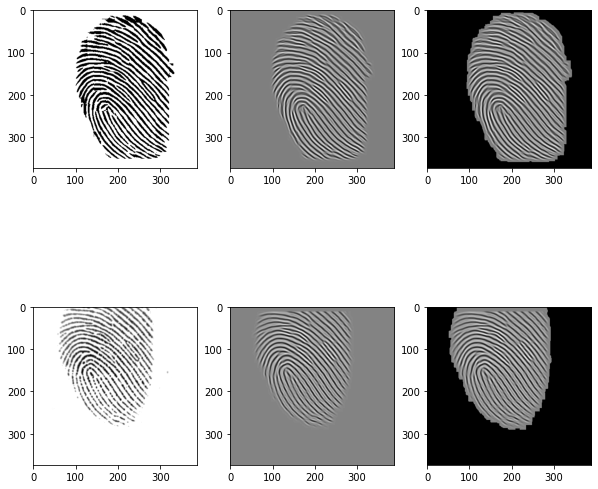

In [ ]:
# Verify by showing some input and processed images

ax = plt.figure()
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(10,10))
ax[0,0].imshow(images_db1[0], cmap='gray')
ax[0,1].imshow(images_enhanced_db1[0], cmap='gray')
ax[0,2].imshow(images_enhanced_db1[0]*masks_db1[0], cmap='gray')

ax[1,0].imshow(images_db1[1], cmap='gray')
ax[1,1].imshow(images_enhanced_db1[1], cmap='gray')
ax[1,2].imshow(images_enhanced_db1[1]*masks_db1[1], cmap='gray')
plt.show()

### 4. Keypoint Extraction and matching
The basis/traditional fingerprint matching algorithm is based on matching keypoints, called minutiae. They are defined as the ridge endings and bifurcations and can be determined by first thresholding the FP image and skeletonizing/thinning the enhanced image. For those really interested (but not part of this assignment) in experimenting with such an approach, some code is provided in the fprmodules/minutiae_extraction folder.

Instead, we will rely on establised methods developed in Computer Vision, where the use of keypoint features has proven to be very succesfull (prior to the advent of Deep Learning) in image classification, image alignment and object recognition tasks.

In this assignment, you are encouraged to try out a series of detection/description/matching algorithms. A short overview of these methods can be found in the OpenCV documentation: [keypoint_detection_descrption_matching](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d).
Please read these pages carefully and try to understand these methods.

#### 4.1 Keypoint detection and feature description

Below, you find one example, that uses ORB features. You can experiment with other feature descriptors and [matching routines](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher) as presented on these pages.

In this template code, we detect and describe keypoints and features. You can test the whole procedure for different detectors. We expect that the keypoints will be detected at "interesting" locations, where locally things seem to change drastically (endings, bifurcations, cores, deltas ...) 

In [ ]:
# call ORB keypoint detector and descriptor
# this can be supplemented with other detectors

def detect_ORB(image, max_features = 500):
    orb = cv2.ORB_create(max_features)
    kp1, desc1 = orb.detectAndCompute(image, None)
    return kp1, desc1

In [ ]:
# many false keypoints will be generated at the edge of the foreground mask, since ridges seem to terminate due to the clipping.
# we remove these by a morpholigical erosion (shrinking) of the foreground mask and deleting the keypoints outside.

def remove_edge_kps(mask, kp, desc):
    mask_b = mask.astype(np.uint8)  #convert to an unsigned byte
    # morphological erosion
    mask_b*=255
    mask_e = cv2.erode(mask_b, kernel = np.ones((5,5),np.uint8), iterations = 5)
    # remove keypoints and their descriptors that lie outside this eroded mask
    kpn = [kp[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255]
    descn = np.vstack([desc[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255])
    return kpn, descn

<Figure size 432x288 with 0 Axes>

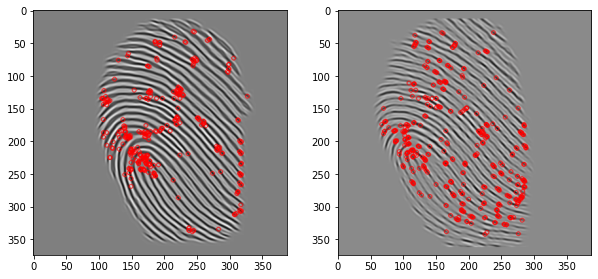

In [ ]:
# test example

testNr1 = 0
testNr2 = 7
# find the keypoints and descriptors with ORB for two images of the same finger

kp1, des1 = detect_ORB(images_enhanced_db1[testNr1], max_features = 500)
kp1, des1 = remove_edge_kps(masks_db1[testNr1], kp1, des1)

kp2, des2 = detect_ORB(images_enhanced_db1[testNr2], max_features = 500)
kp2, des2 = remove_edge_kps(masks_db1[testNr2], kp2, des2)

# plot the keypoints and inspect how genuine they are and if there is a subset that seems to match left and right
show_img1 = cv2.drawKeypoints(images_enhanced_db1[testNr1], kp1, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
show_img2 = cv2.drawKeypoints(images_enhanced_db1[testNr2], kp2, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(show_img1)
ax[1].imshow(show_img2)
plt.show()

#### 4.2 Local Matching by feature vector comparison

Once all images have been processed we can start matching the keypoints between the images. 

We can do this on a purely **local level** by comparing the feature decriptors in one image with the feature descriptors in the other image. Note that these feature descriptors give a vectorial summary of the neighbourhood around each keypoint. A simple metric on these vectors (Euclidean Distance for continuous variables, Hamming Distance for binary variables) can then be used to determine similarity. 

A simple Brute Force matching strategy is to measure these distances between every possible pair of keypoints (descriptors) in both images. We can then define simple scalar measures on this set of distances, such as the number of pairs with a distance smaller than a set threshold, or the sum/mean of the first N distances (ranked from small to larger), etc. 


In [ ]:
# Brute Force matcher on a pair of KeyPoint sets using the local descriptor for similarity

def match_BruteForce_local(image1, image2, des1, des2):
        
    # Brute Force all pair matcher: returns all pairs of best matches
    # depending on type of descriptor use the corresponding norm
    # crossCheck=True only retains pairs of keypoints that are each other best matching pair
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    # sort matches based on feature distance
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    return matches

matches = match_BruteForce_local(images_enhanced_db1[testNr1], images_enhanced_db1[testNr2], des1, des2)

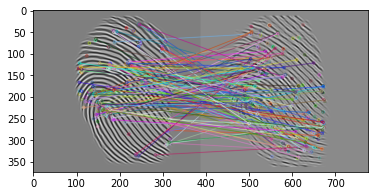

(<matplotlib.image.AxesImage at 0x7f1ea04fde10>, None)

In [ ]:
# show the result using drawMatches

imMatches = cv2.drawMatches(images_enhanced_db1[testNr1],kp1,
                            images_enhanced_db1[testNr2],kp2,matches, None) 
plt.imshow(imMatches),plt.show()

#### 4.3 Global matching by testing geometrical consistency

[Here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) you can find a decsription and code how to start from the brute force matching results and estimate the best transformation (from a family of transformations) that aligns the two images. In the example given [here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/), a homography-type transformation is searched for. However, this has too many degrees of freedom for our application. We substituted this by a more constrained (only 4 degrees of freedom) similarity (partial affine) transformation.
These routines iteratively determine the minimal set of matching points that define a transformation that optimally aligns all other points as well, taking care of outliers at the same time. This method is a very general optimization technique and is called RANSAC, for "RANdom SAmple Consensus". See, apart from many other sources on the internet, [this presentation](http://www.cse.psu.edu/~rtc12/CSE486/lecture15.pdf) for further explanation. 

In [ ]:
def match_BruteForce_global(image1, image2, kp1, kp2, matches, good_match_percent = 0.75):
    
    # a local function required to transform key_points by a certain transformation matrix
    def transform_keypoints(key_points, transformation_matrix):
        # convert keypoint list to Nx1x2 matrix
        mat_points = cv2.KeyPoint.convert(key_points).reshape(-1,1,2)
        # transform points 
        mat_reg_points = cv2.transform(mat_points, transformation_matrix)
        # return transformed keypoint list
        return cv2.KeyPoint.convert(mat_reg_points)    

    # select the best x percent best matches (on local feature vector level) for further global comparison
    GOOD_MATCH_PERCENT = good_match_percent
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    good_matches = matches[:numGoodMatches]
   
    # retain only the keypoints associated to the best matches 
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # estimate an optimal 2D affine transformation with 4 degrees of freedom,
    # limited to combinations of translation, rotation, and uniform scaling
    
    # this is the core of the global consistency check: if we find the correct transformation
    # (which we expect for genuine pairs and not for imposter pairs), we can use it as an
    # additional check by verifying the geometrical quality of the match
    
    # M stores the optimal transformation
    # inliers stores the indices of the subset of points that were finally used to calculate the optimal transformation
    
    M, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method =  cv2.RANSAC, 
                                             confidence = 0.9, ransacReprojThreshold = 10.0, 
                                             maxIters = 5000, refineIters = 10)

    # get the inlier matches
    matched = [x for x,y in zip(good_matches, inliers) if y[0] == 1]

    # The optimal transformation is only correct for genuine pairs in about 75% of cases (experimentally on dataset DB1).
    # One can build additional checks about the validity of the transformation,
    # e.g. too large translations, rotations and/or scale factors
    
    # A simple one is to test the number of keypoints that were used in calculating the transformation. 
    # If this number is is too small, then the transformation is most possibly unreliable. 
    # In that case, we reset the transformation to the identity
    if np.sum(inliers) < 5:
        M = np.eye(2, 3, dtype=np.float32)

    # transform the first keypoint set using the transformation M
    kp1_reg = transform_keypoints(kp1, M)
                                              
    return kp1_reg, matched, M

In [ ]:
kp1_reg, matched, M = match_BruteForce_global(images_enhanced_db1[testNr1],
                                              images_enhanced_db1[testNr2],
                                              kp1,kp2, matches, good_match_percent = 0.75)

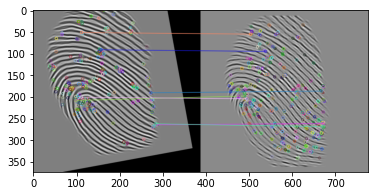

Affine_#inliers:7


<Figure size 432x288 with 0 Axes>

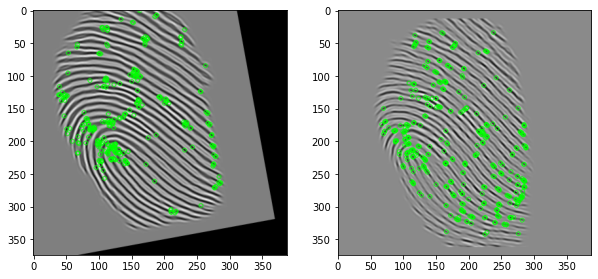

In [ ]:
# visualization of the matches after affine transformation
height, width = images_enhanced_db1[testNr2].shape[:2]
im1Reg = cv2.warpAffine(images_enhanced_db1[testNr1], M, (width, height))

# only the inlier matches (matched) are shown
imMatches = cv2.drawMatches(im1Reg, kp1_reg, images_enhanced_db1[testNr2], kp2, matched, None) #, flags=2)
plt.imshow(imMatches), plt.show()

# Note; the hypothesis is that the transformation will be most of the time OK for genuine
# pairs, but wrong for imposter pairs. 

# show all keypoints after geometric matching

print("Affine_#inliers:{}".format(len(matched)))
show_img1 = cv2.drawKeypoints(im1Reg, kp1_reg, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
show_img2 = cv2.drawKeypoints(images_enhanced_db1[testNr2], kp2, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(show_img1)
ax[1].imshow(show_img2)
plt.show()


## TASKS

Implement the following tasks for one of the 4 databases. I suggest either DB1 or DB2, since they seem a little easier.

#### <font color=blue> Task 1 Test different Keypoint Detectors/Descriptors

* OpenCV provides different KeyPoint detectors and descriptors (ORB, SIFT, SURF, BRIEF, ...). Briefly test, visually, which of these seem to extract relatively reliable interesting points from the fingerprints.
* Note that for some of the KeyPoint descriptors, you need to have a special licence or a full implementation. Skip if you do not have it.
* You also may have to tune the parameters of these detectors.
* But don't spend too much time on this testing step. 
* If you do have the time and the computational resources, you can compare not just visually but by calculating all through using ROC and CMC curves as evidence (Cf. task 3)
</font>

In [ ]:
def get_SIFT_features(img,index):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=400,contrastThreshold=0.00001,edgeThreshold=60)
    SIFT_kp, des = sift.detectAndCompute(img[index].copy(),None)
    return SIFT_kp, des

In [ ]:
def get_BRIEF_features(img,index):
    star = cv2.xfeatures2d.StarDetector_create(maxSize = 10,responseThreshold = 30,lineThresholdProjected = 50,lineThresholdBinarized = 25,suppressNonmaxSize = 10 )
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(use_orientation = False)
    kp = star.detect(img[index].copy(),None)
    BRIEF_kp, des = brief.compute(img[index].copy(), kp)
    return BRIEF_kp, des
    

In [ ]:
"""
index = 0
SIFT_kp,SIFT_des = get_SIFT_features(images_enhanced_db1,index)
img_sift = cv2.drawKeypoints(images_enhanced_db1[index].copy(), SIFT_kp, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
"""

'\nindex = 0\nSIFT_kp,SIFT_des = get_SIFT_features(images_enhanced_db1,index)\nimg_sift = cv2.drawKeypoints(images_enhanced_db1[index].copy(), SIFT_kp, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)\n'

In [ ]:
index  = 2
BRIEF_kp,BRIEF_des = get_BRIEF_features(images_enhanced_db1,index)
img_brief = cv2.drawKeypoints(images_enhanced_db1[index].copy(), BRIEF_kp, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)


<Figure size 432x288 with 0 Axes>

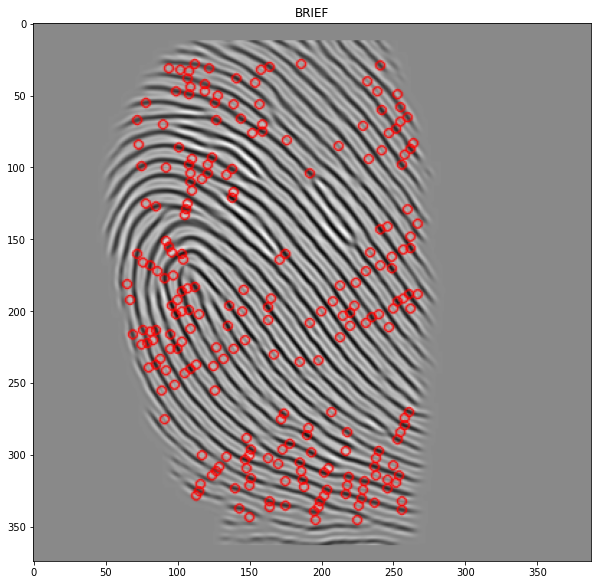

In [ ]:
ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10))
ax.imshow(img_brief)
ax.title.set_text('BRIEF')
#ax[1].imshow(img_sift)
#ax[1].title.set_text('SIFT')

plt.show()

#### <font color=blue> Task 2. Determine a matching function
    
You have been given code to calculate matches on a local level and to calculate an affine transformation that allows a more global consistency check. 
    
Define and test different matching functions that make use of these two-level features.
    
1. a function based only on the local features (e.g. number of pairs with feature distance below a set distance threshold, the sum or mean of the feature distance of the best N pairs, or any other function you think is a good candidate)
2. a function based on the geometrical distances between pairs of KeyPoints are affine transformation. For instance, you can take again a brute force matcher that, instead of pairwise feature descriptor distances, computes pairwise geometrical distances between the two point sets. From there on you can then define different measures (number of below a threshold or sum/mean of distances, ...). You can also limit the number of point pairs to apply this to to the matching pairs that result from the local match and/or the ones that are returned as 'matched' by the Ransac procedure. 
3. any combination of local and global match metrics
    
</font>

### We create a function that does bruteforce matching using hamming distance.

In [ ]:
def get_hamming_dist_match(descrip1,descrip2):
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descrip1,descrip2,None)
    matches = sorted(matches,key= lambda x:x.distance)
    return matches

### Another function that does matching based on the L1-norm.

In [ ]:
def get_norm_L2_match(descrip1,descrip2):
    matcher = cv2.DescriptorMatcher_create(cv2.NORM_L1)
    matches = matcher.match(descrip1,descrip2,None)
    matches = sorted(matches,key= lambda x:x.distance)
    return matches

### We compute the descriptors and keypoints based on hamming distance.

In [ ]:
index = 0
img1 = images_enhanced_db1[index].copy()
BRIEF_kp1,BRIEF_des1 = get_BRIEF_features(images_enhanced_db1,index)
index = 2
img2 = images_enhanced_db1[index].copy()
BRIEF_kp2,BRIEF_des2 = get_BRIEF_features(images_enhanced_db1,index)
#Compare the same finger for test
matches = get_hamming_dist_match(BRIEF_des1,BRIEF_des2)
matches_same_finger = get_hamming_dist_match(BRIEF_des2,BRIEF_des2)
#draw the image

### Next we plot these features that we computed using hamming distance.

<Figure size 432x288 with 0 Axes>

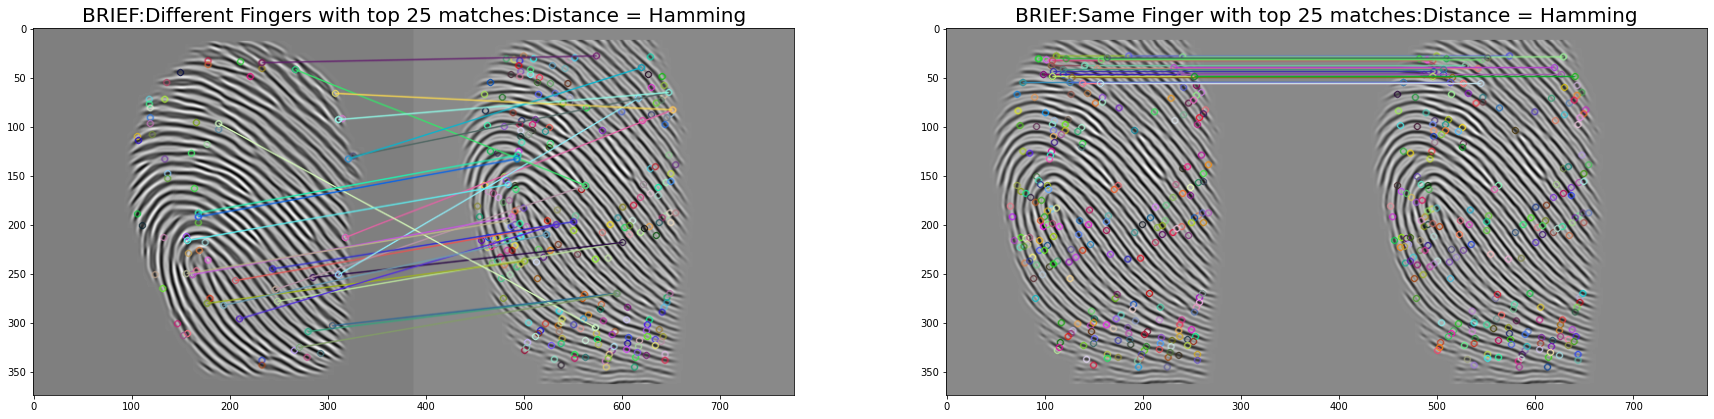

In [ ]:
top = 25
img3 = cv2.drawMatches(img1.copy(),BRIEF_kp1,img2.copy(),BRIEF_kp2,matches[:top],None)
img_for_same_finger = cv2.drawMatches(img2.copy(),BRIEF_kp2,img2.copy(),BRIEF_kp2,matches_same_finger[:top],None)

ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(30,30))
ax[0].imshow(img3)
ax[1].imshow(img_for_same_finger)
ax[0].set_title("BRIEF:Different Fingers with top "  + str(top) + " matches:Distance = Hamming",fontsize=20)
ax[1].set_title("BRIEF:Same Finger with top " + str(top)+ " matches:Distance = Hamming",fontsize=20)
plt.show()

### We make another function call but this time we use the bruteforce approach with L1-norm.

In [ ]:
index = 0
img1 = images_enhanced_db1[index].copy()
BRIEF_kp1,BRIEF_des1 = get_BRIEF_features(images_enhanced_db1,index)
index = 10
img2 = images_enhanced_db1[index].copy()
BRIEF_kp2,BRIEF_des2 = get_BRIEF_features(images_enhanced_db1,index)
#Compare the same finger for test
matches_same_finger = get_norm_L2_match(BRIEF_des2,BRIEF_des2)
#draw the image

#### <font color=blue>  Task 3 Test complete system for authentication and identification scenario's

* Choose (at least) one of the databases provided
* calculate the ROC (false match to false non match rate) for an authentication scenario 
* and a Cumulative Match Characteristic (CMC) curve, which plots the rank (order in the candidate list) on the x-axis and the probability of identification at that or better rank on the y-axis. Feel free to reuse your code of the previous assignment!

* Of course you can calulate and store the features upfront before starting the validation procedures.
* Also follow the pipeline and the datastructure of the first assignment on validation, where you calculated genuine and imposter scores (cf. the genuine_id and scores lists that you generated)
    
    
    
</font>

#### Identification scenario where we find out the indentity of a person by comparing the query with all the images in the database.



##### We first select a databased.

In [ ]:
selected_db = images_db4
selected_labels = labels_db4

##### This function takes the list of matched scores and returns the average.

In [ ]:
def convert_to_score(matches,total_points_retain):
    sum = 0
    for i in range(len(matches)):
        sum = sum+matches[i].distance
    return (sum/len(matches))

##### Following function takes as input the query index and compares it with images of whole database and returns minimum of the matched scores for that query.

In [ ]:
#index: Index of the query image.
#total_points_retain : How many point we want to retain in matched list.
#f_extractor : It can be SIFT or BRIEF.
def find_identity(index,database,total_points_retain,threshold,f_extractor):
    list_of_scores = []
    BRIEF_kp1,BRIEF_des1 = f_extractor(database,index)
    for i in range(len(database)):
        if (i!=index):
           BRIEF_kp2,BRIEF_des2 = f_extractor(database,i)
           matches = get_hamming_dist_match(BRIEF_des1,BRIEF_des2)
           matches = matches[:total_points_retain]
           list_of_scores.append(convert_to_score(matches,total_points_retain))
    list_of_scores = np.array(list_of_scores)
    return np.argmin(list_of_scores),list_of_scores[np.argmin(list_of_scores)]


##### Following function takes as input a database,labels,feature_extactor and how many points to retain. It computes target for each query image.

In [ ]:
#database: The database that we have selected.
#labels: Labels corresponding to that database.
#total_points_retain: How many points we want to retain.
#threshold: It is not used as i am using local features.
#f_extractor : SIFT or BRIEF.

def indentify_database(database,labels,total_points_retain,threshold,f_extractor):
    final_scores = []
    final_index = []
    for i in range(len(database)):
        index,indentity = find_identity(i,database,total_points_retain,threshold,f_extractor)
        final_scores.append(indentity)
        final_index.append(index)
    return final_index,final_scores
        
        

##### Following function takes scores and true labels as input and builds two separate lists of genuine vs imposter scores.

In [ ]:
def convert_to_imp_gen_dist(scores,indexes,true_labels):
    imposter = []
    genuine = []
    all_scores = []
    assert len(scores) == len(indexes)
    for i in range(len(scores)):
        all_scores.append(scores[i])
        if (true_labels[i] == true_labels[indexes[i]]):
           genuine.append(scores[i])
        else:
           imposter.append(scores[i])
    return genuine,imposter,all_scores

##### Now we plot the genuine and imposter scores



In [ ]:
def plot_gen_imp_dis(genuine,imposter,axes):
  #First create the weights for normalized version of the plots.
  weights = np.ones_like(genuine)/float(len(genuine))
  weights2 = np.ones_like(imposter)/float(len(imposter))
  #Parameters that define type of the curve and number of bins.
  kwargs = dict(histtype='stepfilled', alpha=0.7,  bins=15)
  #Finally plot the histogram.
  axes.hist(genuine,**kwargs, weights=weights,label = 'genuine_score')
  axes.hist(imposter,**kwargs, weights=weights2,label = 'imposter_score')
  axes.legend()


##### Next we import the sns libaray and plot the distplot. We plot distribution by normalizing them together and also normalizing them separately because if we normalize them together then we can read the boundary nicely.

In [ ]:
import seaborn as sns

def plot_distributions(genuins_score,imposter_score,ax1):
    g = sns.distplot(genuins_score,hist=True, ax=ax1,kde=True, rug=False,label='Genuine_Score',color='GREEN')
    g2 = sns.distplot(imposter_score,hist=True, ax=ax1,kde=True, rug=False,label='Imposter_score',color='RED')
    ax1.legend()
    fig.suptitle("Distributions of Genuine and imposter score" , fontsize=16,color="BLACK")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##### Following function is used to calculate number of elements that are greater than a specific score. It will be used to compute FMR and FRR.

In [ ]:
#scores : list of soreted scores.
#list_of_dist_val: List of values of distributions.
def get_list_of_increasing_number(scores,list_of_dist_vals):
    previous_j = 0
    previous_sum = 0
    total_greater_values = 0
    len_of_scores = len(scores)
    len_of_dist_list = len(list_of_dist_vals)
    to_return_list = []
    for i in range(len_of_scores):
        total_greater_values = previous_sum
        for j in range(previous_j,len_of_dist_list):
            if(list_of_dist_vals[j] >= scores[i]):
                total_greater_values = total_greater_values + 1
            elif(list_of_dist_vals[j] < scores[i]):
                previous_j = j
                previous_sum = total_greater_values
                break
        normalized = ((total_greater_values))/len_of_dist_list
        to_return_list.append(normalized)
    return to_return_list

##### Here we compute the FRR and FMR by calling the function defined above.




#####We first remove all the duplicate scores from the combined scores and sort it. Next, we compute for each score how many elements are greater than that score in genuine and imposter list. We reverse the FRR list and return the scores. We sorted the all_scores list only for efficiency reason.


In [ ]:
#all_scores: Scores all combined.
#genuine: Separate list of genuine scores.
#imposter: Separate list of imposter scores.


def get_FRR_FMR(all_scores,genuine,imposter):
    removed_dup_scores = list(set(all_scores))
    sorted_score = sorted(removed_dup_scores,reverse=True)
    sorted_imposter = sorted(imposter,reverse=True)
    sorted_genuine = sorted(genuine,reverse=True)
    FMR_list = get_list_of_increasing_number(sorted_score,sorted_imposter)
    FRR_list = get_list_of_increasing_number(sorted_score,sorted_genuine)
    FRR_list.sort(reverse=True)
    return FRR_list,FMR_list,sorted_score

##### Following function is used to plot the FMR and FRR.

In [ ]:
"""Plot FAR and FRR as a function of matching scores."""
def plot_FMR_FRR(sorted_score_li,FMR,FRR,bool_val,axes):
    first_plot, = axes.plot(sorted_score_li,FMR,color='RED',label='FMR',marker=".")
    axes.legend(loc="upper right")
    second_plot, = axes.plot(sorted_score_li,FRR,color='BLUE',label='FRR',marker=".")
    axes.legend(loc="upper right")
    axes.title.set_text("FMR vs FRR")
    axes.set_xlabel('Scores/Threshold')
    axes.set_ylabel('% FMR or FRR')
    if(bool_val):
        axes.set_xscale('log')
        axes.set_xlabel('Scores/Threshold in log scale')

#####A helper function which is used to find the true label at index i(from the true labels list).

In [ ]:
def get_predicted_labels(indexes,true_labels):
    predicted_labels = []
    for i in range(len(indexes)):
        predicted_labels.append(true_labels[indexes[i]])
    return predicted_labels

##CMC

##### Following function retrieves all the image for given target.

In [ ]:
#target: label of a person.
#labels: list of labels which will be used to find all indexes.
#images: all images.
def get_all_images(target,labels,images):
    images_copy = []
    indexes = [i for i in range(len(labels)) if labels[i] == target]
    for i in range(len(indexes)):
        images_copy.append(images[indexes[i]])
    return np.array(images_copy)

##### Function to compute BRIEF feature descriptors.

In [ ]:
def get_BRIEF_feature_vec(img_first):
    star = cv2.xfeatures2d.StarDetector_create(maxSize = 10,responseThreshold = 30,lineThresholdProjected = 50,lineThresholdBinarized = 25,suppressNonmaxSize = 10 )
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(use_orientation = False)
    kp = star.detect(img_first.copy(),None)
    BRIEF_kp, des = brief.compute(img_first.copy(), kp)
    return BRIEF_kp, des

In [ ]:
"""def get_BRIEF_feature_ve(img_first):
    star = cv2.xfeatures2d.StarDetector_create(maxSize = 10,responseThreshold = 30,lineThresholdProjected = 50,lineThresholdBinarized = 25,suppressNonmaxSize = 10 )
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(use_orientation = False)
    kp = star.detect(img_first.copy(),None)
    BRIEF_kp, des = brief.compute(img_first.copy(), kp)
    return BRIEF_kp, des"""

'def get_BRIEF_feature_ve(img_first):\n    star = cv2.xfeatures2d.StarDetector_create(maxSize = 10,responseThreshold = 30,lineThresholdProjected = 50,lineThresholdBinarized = 25,suppressNonmaxSize = 10 )\n    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(use_orientation = False)\n    kp = star.detect(img_first.copy(),None)\n    BRIEF_kp, des = brief.compute(img_first.copy(), kp)\n    return BRIEF_kp, des'

##### Next function is used to compare the images of the person by making use of above defined function.

In [ ]:
def compare_score(images_first,images_second,total_points_retain,f_extractor):
    BRIEF_kp1,BRIEF_des1 = f_extractor(images_first)
    BRIEF_kp2,BRIEF_des2 = f_extractor(images_second)
    matches = get_hamming_dist_match(BRIEF_des1,BRIEF_des2)
    matches = matches[:total_points_retain]
    sum = convert_to_score(matches,total_points_retain)
    return sum


In [ ]:
import pprint

##### Following function takes as input a databased and compares all the images of the database to create a similarity matrix.


##### It does so by comparing all the images of two different targets pairwise and then taking the average of all the scores obtained by pairwise matching.

In [ ]:
def match_all_images_pair_wise(selected_db,selected_labels,total_points_retain,f_extractor):
    unique_labels = sorted(list(set(selected_labels)))
    score = 0
    n = len(unique_labels)
    sim_matrix =   np.zeros((n,n,100))
    sim_matrix = np.array(sim_matrix)
    display(sim_matrix.shape)
    display(len(sim_matrix))
    for i in range(len(unique_labels)):
      for j in range(len(unique_labels)):
          k =0
          images_first  = get_all_images(unique_labels[i],selected_labels,selected_db)
          images_second  = get_all_images(unique_labels[j],selected_labels,selected_db)
          for s in range(len(images_first)):
            for t in range(len(images_second)):  
                score  = compare_score(images_first[s],images_second[t],total_points_retain,f_extractor)
                sim_matrix[i][j][k] = score
                k = k+1
    return sim_matrix

##### A helper function which normalizes the scores.

In [ ]:
def get_sum(sim_matrix):
    n = len(unique_labels)
    new_matrix = np.zeros((n,n))
    for i in range(len(unique_labels)):
        for j in range(len(unique_labels)):
            vect = sim_matrix[i][j]
            for k in range(len(vect)):
                new_matrix[i][j] = new_matrix[i][j]+vect[k]
            if(i == j):
               new_matrix[i][j] = new_matrix[i][j]/(len(vect)-1)
            else:
              new_matrix[i][j] = new_matrix[i][j]/(len(vect))
    return new_matrix

##### Finally this function will be used to compute the scores(TPIR) to plot a cmc matrix.

In [ ]:
  # 1.1) compute the rank of the column elements (enrollees) for every row (user)
    # 1.2) calculate how frequent each rank occurs on the diagonal (diagonal contains the correct identifications)  
    # 1.3) compute the cumalulative frequency for each rank and normalise the result 
    # 1.4) return the CMC

def CMC(similarity_matrix, n_ranks):
    copy = similarity_matrix.copy()
    rows,cols = copy.shape
    ranks_count = [0]*n_ranks 
    normalized = [0]*n_ranks
    for i in range(0,rows):
        element = copy[i][i]
        row = list(copy[1])
        row = sorted(row,reverse=True)
        greater_vals = len([i for i in row if i >= element])
        if(greater_vals < n_ranks):
           val = ranks_count[greater_vals]
           val = val+1
           ranks_count[greater_vals] = val
    total_sum = 0
    for i in range(0,n_ranks):
      total_sum = total_sum + ranks_count[i]
      normalized[i] = total_sum/rows
  
    return normalized

##### A function to plot the cmc curve.

In [ ]:
def plot_cmc(n_ranks,result_ri,axes):
  ranks = []
  for i in range(1,n_ranks+1):
    ranks.append(i) 
  axes.plot(ranks,result_ri,color="RED",marker="",label='RightIndex')
  axes.set_xlabel("Ranks")
  axes.set_ylabel("TPIR")
  axes.title.set_text("CMC curve")

In [ ]:
#Select the feature extractor.
feature_extractor = get_BRIEF_features
#Get scores along with the indexes.
indexes,scores = indentify_database(selected_db,selected_labels,25,-1,feature_extractor)
#Get the genuine and imposter scores separated.
genuine,imposter,all_scores = convert_to_imp_gen_dist(scores,indexes,selected_labels)
#Calculated FMR and FRR scores.
FRR,FMR,sorted_score = get_FRR_FMR(all_scores,genuine,imposter)


##### Unique labels that will be used later.*italicised text*

In [ ]:
unique_labels =  sorted(list(set(selected_labels)))

##### Following function does the same thing as above defined function but for cmc matrix.

In [ ]:
#Select the feature extractor.
feature_extractor = get_BRIEF_feature_vec
#Get the similarity matrix.
images_first  = match_all_images_pair_wise(selected_db,selected_labels,35,feature_extractor)
#Get the cmc matrix after normalizing.
cmc_matrix  = get_sum(images_first)

(10, 10, 100)

10

##### Call the CMC function with cmc matrix and ranks.

In [ ]:
n_ranks = 20
cmc_matrix_normalized = CMC(cmc_matrix,n_ranks)

##### Finally plot all the thing together(distribution, FMR ,FRR and cmc)

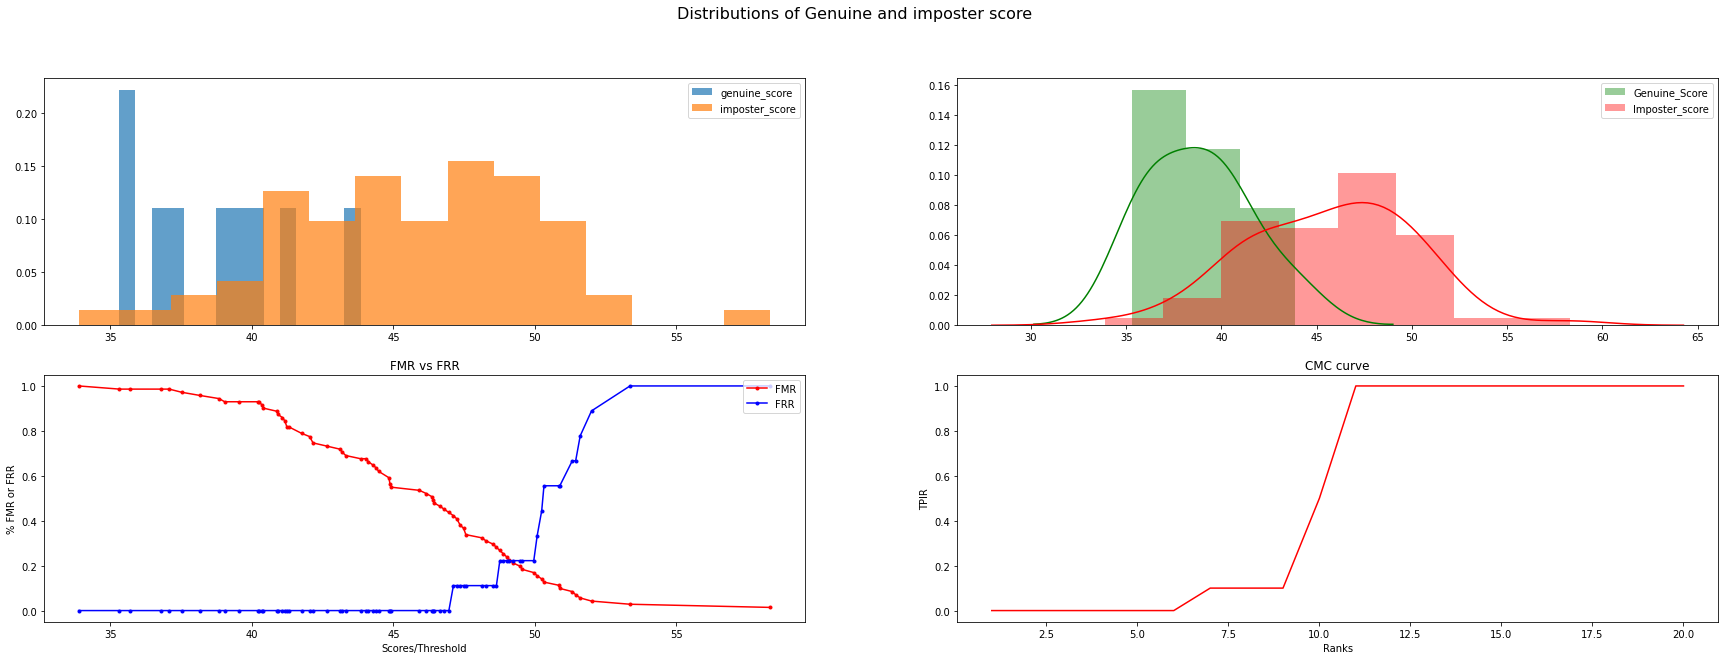

In [ ]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharey=False, sharex=False,figsize=(30,10))
plot_gen_imp_dis(genuine,imposter,ax1)
plot_distributions(genuine,imposter,ax2)
plot_FMR_FRR(sorted_score,FMR,FRR,False,ax3)
plot_cmc(n_ranks,cmc_matrix_normalized,ax4)
plt.show()

#### Now we plot ROC curve for authentication scenario.

In [ ]:
images_sel = selected_db
labels_sel = selected_labels

In [ ]:
import random


#### We have multiple classes and we want to draw an ROC curve which shows False positive rate vs True positive rate. We need to convert our problem so that we have only two labels which are 0 and 1.

##### We take a query image and compare it with all other images of the same person's image(same target number) and take the  minimum of the scores that we get. We store these scores with label = 1.

##### For each query image, we also take randomly images from the other persons images. For each of the these images, we store the scores along with the label = 0.

##### Following function takes a target label and compares it with all the images(except that image that we take as query) of the same person's images. It returns the smallest distance which is obtained by comparing the query image with all the images of the same person.

In [ ]:
def get_scores_for_true(target,images_sel,labels,total_points_retain):
    indexes = [i for i in range(len(labels)) if labels[i] == target]
    query_index = indexes[random.randint(0, len(indexes)-1)]
    query_image = images_sel[query_index]
    BRIEF_kp1,BRIEF_des1 = get_BRIEF_feature_vec(query_image)
    current_dist = 1000
    for i in range(len(indexes)):
        if (indexes[i] != query_index):
            BRIEF_kp2,BRIEF_des2 = get_BRIEF_feature_vec(images_sel[indexes[i]])
            matches = get_hamming_dist_match(BRIEF_des1,BRIEF_des2)
            matches = matches[:total_points_retain]
            sum = convert_to_score(matches,total_points_retain)
            if(sum < current_dist):
               current_dist = sum
    return current_dist,query_index

##### We need another function that takes as input a query image and compares it with all randomly selected images of other persons. Here we compare a query of person i with randomly selected images of person j where j is randomly selected and person j is different from person i.

In [ ]:
def get_score_for_false(target,query_index,images_sel,labels,total_points_retain):
    indexes = [i for i in range(len(labels)) if labels[i] != target]
    query_image = images_sel[query_index]
    index_imposter = indexes[random.randint(0, len(indexes)-1)]
    BRIEF_kp1,BRIEF_des1 = get_BRIEF_feature_vec(query_image)
    BRIEF_kp2,BRIEF_des2 = get_BRIEF_feature_vec(images_sel[index_imposter])
    BRIEF_kp2,BRIEF_des2 = get_BRIEF_feature_vec(images_sel[indexes[i]])
    matches = get_hamming_dist_match(BRIEF_des1,BRIEF_des2)
    matches = matches[:total_points_retain]
    sum = convert_to_score(matches,total_points_retain)
    return sum

#####For each target person, we take his one image and compare it with all his image and take the smallest number as best match(we are using distance). 

##### For each target person, we also compare his image with images of other persons. These images will saved with label 0 and scores as the score that we get.

In [ ]:
predicted_socres = []
true_labels = []
iter = 3
for j in range(len(unique_labels)):
  for i in range(iter):
    scores_true,query_index = get_scores_for_true(unique_labels[j],images_sel,labels_sel,50)
    true_labels.append(1)
    predicted_socres.append(scores_true)
    scores_false = get_score_for_false(unique_labels[j],query_index,images_sel,labels_sel,50)
    true_labels.append(0)
    predicted_socres.append(scores_false)

#####We are using distance but roc_curve function of sklearn requires that the input is similarity based. So we have to conver the scores from distance to similarity.

In [ ]:
def get_rescaled_list(dist_list):
    arr = np.array(dist_list)
    sum  = np.sum(arr)
    arr = (arr/sum)*10
    arr = 1-arr
    return arr

#####Get the rescaled list of scores.

In [ ]:
predicted_socres = get_rescaled_list(predicted_socres)

##### Compute the roc curve.

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_socres, pos_label=None)

##### Finally we plot the ROC curve.

Text(0, 0.5, 'True Positive Rate')

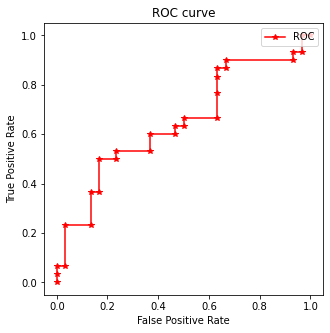

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.plot(fpr, tpr, color='Red', label="ROC",marker="*")
axes.legend(loc="upper right")
axes.title.set_text("ROC curve")
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')

#### <font color=blue>  Task 4 Discuss your results
    
* which parts are critical?
* given more time, how would you improve?
* compare your results to the results that are available [online](http://bias.csr.unibo.it/fvc2002/results.asp) 

##### We have good results in the indentification scenario but for the verification,results are not good. The reason is that we are using feature based approach without using the knowledge of domain. Hence, the difference between the scores is very small,that we obtain by comparing an image of a person with his own image and the score that we obtain by comparing his image to someone's else image.

##### If more time is given, then we can implement the finger print recognition algorithms based on minutiae extraction that we  have seen in lectures. 